In [1]:
%matplotlib inline
import sys, os, ase, itertools, numpy as np

from ase import Atoms
from ase.visualize import view
from ase.data.colors import jmol_colors

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D

# from quippy import Atoms as qpAtoms
# import quippy as qp

from tqdm import tqdm_notebook, tnrange, tqdm

from samos.analysis.rdf import RDF
from samos.analysis import dynamics
from samos.plotting.plot_dynamics import plot_msd_isotropic
from samos.plotting.plot_rdf import plot_rdf
from samos.trajectory import Trajectory


from scipy.spatial.distance import cdist
from sitator.util import PBCCalculator
from sitator.visualization import plot_atoms

# set the path to zeo++ here:
ZEOPP_PATH = "/mnt/d/Downloads/zeo++-0.3/network"

/mnt/d/Internship/Summer Internship 2025/CPDyAnafork-master/CPDyAnafork-master/sitator-master/sitator/util/progress.py:8: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
T = 750
filepath='./data/LASO/Li12Al12Si12O48-act-750-670575-290ps'
trajectory = Trajectory.load_file(filepath)

In [3]:
timestep = trajectory.get_timestep()
print('Sampling timestep is {:.1f} fs\nTotal trajectory lenght is {:.1f}ps'.format(
    timestep, timestep*trajectory.get_positions().shape[0]/1000))

Sampling timestep is 29.0 fs
Total trajectory lenght is 290.6ps


# Calculating the radial distribution function

In [4]:
rdf = RDF(trajectory=trajectory)
# using one of the samos functionalities for that
rdf_res = rdf.run(radius=5.0,
        species_pairs=[('Li', s) for s in set(trajectory.atoms.get_chemical_symbols())], 
        stepsize=5, nbins=80)

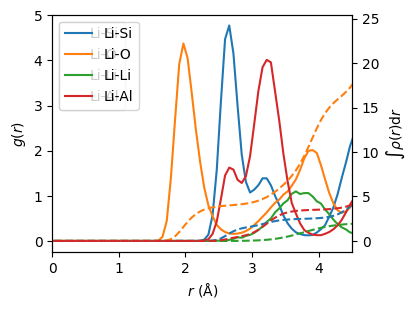

In [5]:
%matplotlib inline
gs = GridSpec(1,1,bottom=0.18, left=0.11, right=0.86, top=0.97)
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(gs[0])
handles = plot_rdf(rdf_res, ax=ax, show=False)
plt.legend(handles=handles[::2])
plt.xlim(0, 4.5)
#plt.savefig('RDF-LASO-{}-Li2all.pdf'.format(T))
plt.show()

# Calculating the MSD to estimate diffusion

In [7]:
d = dynamics.DynamicsAnalyzer(trajectories=[trajectory])
msd = d.get_msd(t_start_fit_fs=25000, t_end_fit_fs=50000, stepsize_tau=10, stepsize_t=1, nr_of_blocks=4,
               species_of_interest=[ "Li"])


    ! Calculating MSD for atomic species Li in trajectory 0
      Structure contains 12 atoms of type Li
      I will calculate 4 block(s) of size 2072 (60.14313988553222 ps)
      I will fit from 861 (24.991912857839402 ps) to 1722 (49.983825715678805 ps)
      Outer stepsize is 1, inner is 10

      Done



(0.0, 10.30171229514268)

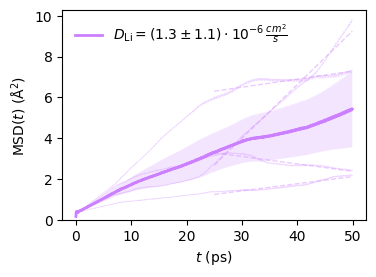

In [8]:
%matplotlib inline
fig = plt.figure(figsize=(4,3))
gs = GridSpec(1,1, left=0.2, right=0.96, top=0.9, bottom=0.2)
ax = fig.add_subplot(gs[0])
plot_msd_isotropic(msd, ax=ax, show=False)
plt.ylim(0,)
#plt.savefig('msd-LASO-{}.pdf'.format(T))

Text(0.5, 0, 'Simulation time / $ps$')

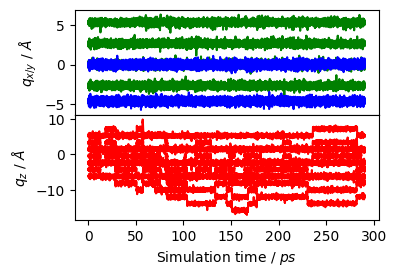

In [9]:
# making a plot of the Li-positions:
li_mask = np.where(trajectory.atoms.get_atomic_numbers()==3)[0]
li_pos = trajectory.get_positions()[:, li_mask, :]
fig = plt.figure(figsize=(4,3))
gs = GridSpec(2,1, left=0.2, right=0.96, top=0.9, bottom=0.2, hspace=0)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
times = trajectory.get_timestep()*np.arange(len(li_pos)) / 1000.
ax1.plot(times, li_pos[:, :, 0], color='g')
ax1.plot(times, li_pos[:, :, 1], color='b')
ax2.plot(times, li_pos[:, :, 2], color='r')
ax1.set_xticks([])
ax1.set_ylabel(r'$q_{x/y}$ / $\AA$')
ax2.set_ylabel(r'$q_{z}$ / $\AA$')
ax2.set_xlabel('Simulation time / $ps$')


In [10]:
species = np.unique(trajectory.atoms.get_atomic_numbers())
static_species = species[species != 3]
#print(species)
print("Static species: %s" % ", ".join([ase.data.chemical_symbols[s] for s in static_species]))
li_mask = (trajectory.atoms.get_atomic_numbers() == 3)
static_mask = np.isin(trajectory.atoms.get_atomic_numbers(), static_species)
static_mask[li_mask] = False

Static species: O, Al, Si


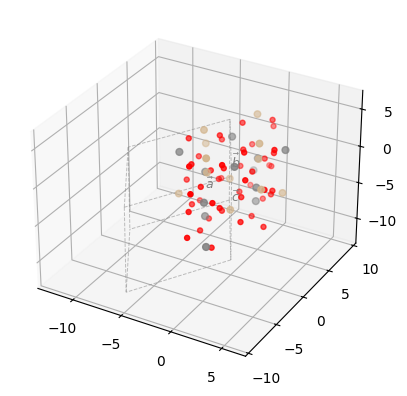

In [11]:

# #starting_positions = trajectory.get_positions()[0]
# pbccalc = PBCCalculator(trajectory.atoms.cell)
# avg_positions = pbccalc.time_average(trajectory.get_positions())
# trajectory.atoms.set_positions(avg_positions)
# ax = plot_atoms(trajectory.atoms[static_mask], positions = trajectory.get_positions()[3][static_mask])

%matplotlib inline
#starting_positions = trajectory.get_positions()[0]
pbccalc = PBCCalculator(trajectory.atoms.cell)
avg_positions = pbccalc.time_average(trajectory.get_positions())
trajectory.atoms.set_positions(avg_positions)
ax = plot_atoms(trajectory.atoms[static_mask], positions = trajectory.get_positions()[3][static_mask])
plt.show()


In [12]:
from sitator.landmark import LandmarkAnalysis
from sitator.voronoi import VoronoiSiteGenerator
from sitator import SiteNetwork, SiteTrajectory
from sitator.util import RecenterTrajectory

landmark_stride = 1 # Compute landmark vectors every sampling step

print("Will compute landmark vectors every %.1f fs (%i frames)." % (
    landmark_stride * trajectory.get_timestep(), landmark_stride))
# Construct a SiteNetwork using the Voronoi decomposition
sn = SiteNetwork(trajectory.atoms, static_mask, li_mask)

# positions = trajectory.get_positions()
# RecenterTrajectory().run(trajectory.atoms, static_mask, positions)
# trajectory.set_positions(positions)

voronoi = VoronoiSiteGenerator(zeopp_path=ZEOPP_PATH)
sn_voro = voronoi.run(sn)
# Calculate and cluster the landmark vectors.

la = LandmarkAnalysis(
                      cutoff_midpoint=1.3,
                      cutoff_steepness=30,
                      minimum_site_occupancy = 0.01,# Minimum occupancy for a site to be considered as such
                      check_for_zero_landmarks=True,
                      clustering_algorithm = 'dotprod',
                      clustering_params = {
                          'clustering_threshold' : 0.9,
                          'assignment_threshold' : 0.9},
                      # peak_evening = 'none',
                      static_movement_threshold = 15.0, # How stringent the analysis should be.
                      dynamic_lattice_mapping = False,
                      relaxed_lattice_checks = False,
                      max_mobile_per_site=2)

la_results = la.run(sn_voro, trajectory.get_positions()[::landmark_stride])

Will compute landmark vectors every 29.0 fs (1 frames).


Landmark Frame: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10010/10010 [00:16<00:00, 622.14it/s]
Clustering iter.: 3it [00:08,  2.84s/it]
Sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120120/120120 [00:04<00:00, 29680.78it/s]


0
1.0
505
(10010, 12)
0.046836496836496835


/mnt/d/Internship/Summer Internship 2025/CPDyAnafork-master/CPDyAnafork-master/sitator-master/sitator/visualization/atoms.py:77: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(pts[:,0], pts[:,1], pts[:,2],


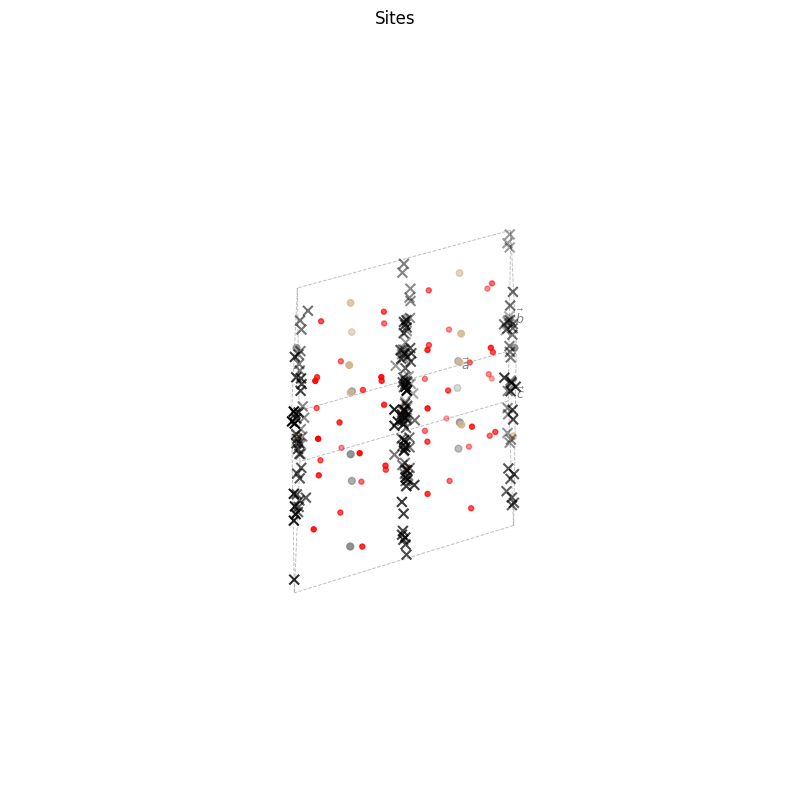

In [13]:
# Her I just print some information on the results:
print(la.n_multiple_assignments) # Number of frames when more than one mobile atom was assigned to one site
print(la.avg_mobile_per_site)
print(la.landmark_dimension)
print(la_results.traj.shape)
print(la_results.percent_unassigned)
from sitator.visualization.atoms import plot_atoms, plot_points
from sitator.visualization.common import layers, grid
la_results.site_network.plot()

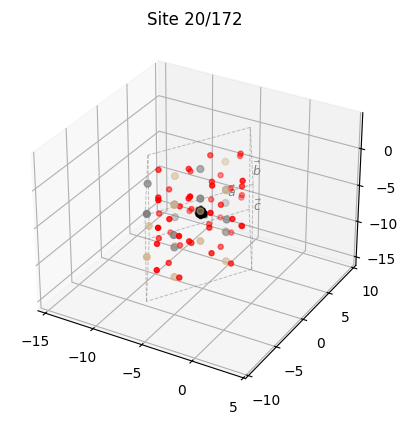

In [14]:
la_results.plot_site(20) # Shows all real-space positions that were assigned to this site.

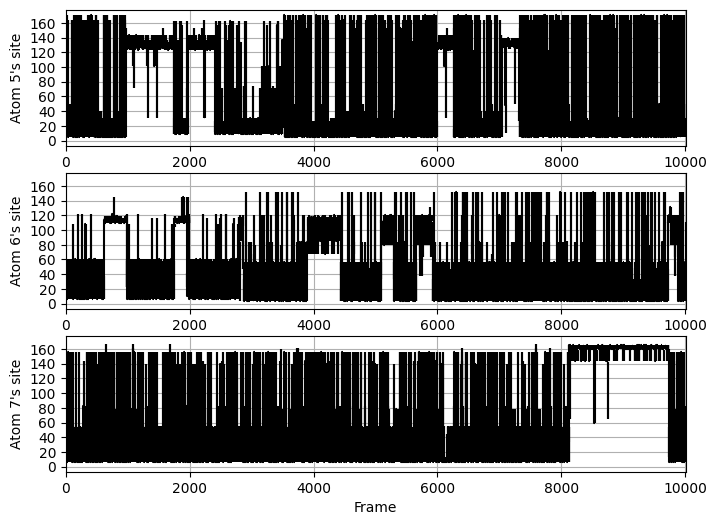

In [15]:
f = grid(*[[(la_results.plot_particle_trajectory, {'particle' : i})] for i in range(5, 8)],
         is3D=False, sharex=True)

In [16]:
import sitator.dynamics.MergeSitesByDynamics

msbd = sitator.dynamics.MergeSitesByDynamics(check_types=False, distance_threshold=2.0, 
                                             markov_parameters=dict(inflation=2, expansion=2))
msbd_res = msbd.run(la_results)

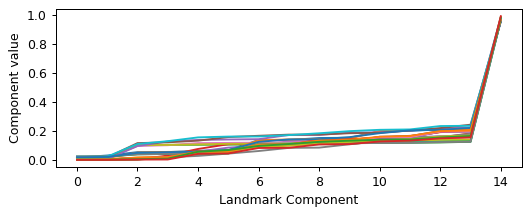

In [17]:
# A utility to print the shape of the landmark vectors.
# This could be useful for a different kind of clustering, purely on
# geometry
n_landmarks = la.landmark_vectors.shape[1]
lbls = np.reshape(msbd_res.traj, la.landmark_vectors.shape[0])
f = plt.figure(dpi = 90, figsize = (6, 2.5))
ax = f.add_subplot(111)
for idx in range(n_landmarks):
    features = la.landmark_vectors[lbls == idx]
    if features.shape[0] > 10: # if site was occupied at least 10 frames
        avglvec = np.mean(features, axis = 0)
        avglvec.sort()
        ax.plot(avglvec[-15:])
ax.set_xlabel("Landmark Component")
ax.set_ylabel("Component value")
f.tight_layout()

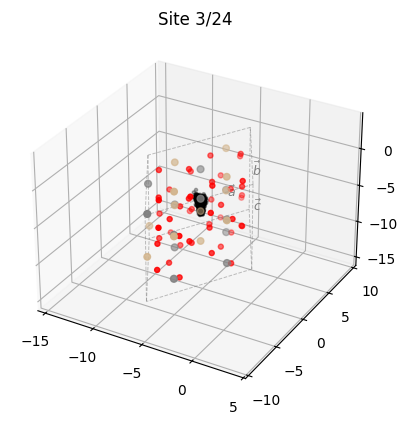

In [18]:
#msbd_res.site_network.plot()
msbd_res.plot_site(3)

In [19]:
# # import sitator.site_descriptors as site_descriptors
# import sitator.site_descriptors as sd

# desc = sd.SOAP.SOAPDescriptorAverages(tracer_atomic_number=3, environment=['Al', 'Si', 'O'], soap_params={
#     'atom_sigma':0.5,'cutoff':4,'n_max':6, 'l_max':6, 'cutoff_transition_width':0.5}, 
#     stepsize=5, averaging=20, verbose=False) #, soap_mask=t.atoms.get_atomic_numbers()==16)
# sta = sd.SiteTypeAnalysis(desc, min_pca_variance=0.95, n_site_types_max=20)
# sta_res = sta.run(msbd_res)
# # desc.get_descriptors(msbd_res)
import sitator.site_descriptors as sd
from sitator.site_descriptors.SOAP import SOAPDescriptorAverages
from sitator.site_descriptors.backend.dscribe_sitator import dscribe_soap_backend

# Ensure msbd_res is defined
try:
    msbd_res
except NameError:
    raise RuntimeError("msbd_res is not defined. Please run the cell that defines msbd_res before running this cell.")

soap_params = {
    'sigma': 0.5,
    'r_cut': 4,
    'n_max': 6,
    'l_max': 6,
    'cutoff_transition_width': 0.5,
    'periodic': True,
    'rbf': 'gto'
}

# Create the backend with your parameters
backend = dscribe_soap_backend(soap_params=soap_params)
print("Backend type:", type(backend))
print("Backend:", backend)

# Pass the backend to SOAPDescriptorAverages
desc = SOAPDescriptorAverages(
    tracer_atomic_number=3,
    environment=['Al', 'Si', 'O'],
    stepsize=5,
    averaging=20,
    backend=backend
)
desc.get_descriptors(msbd_res)
sta = sd.SiteTypeAnalysis(desc, min_pca_variance=0.95, n_site_types_max=20)
sta_res = sta.run(msbd_res)


Backend type: <class 'function'>
Backend: <function dscribe_soap_backend.<locals>.backend at 0x7fdd3933c4a0>


SOAP Frame: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2002/2002 [00:02<00:00, 788.38it/s]


(<Figure size 400x300 with 1 Axes>,
 <Axes: title={'center': 'Descriptor Clustering'}, xlabel='$1^{st}$ comp. (92% of $\\sigma^2$)', ylabel='$2^{nd}$ comp. (4% of $\\sigma^2$)'>)

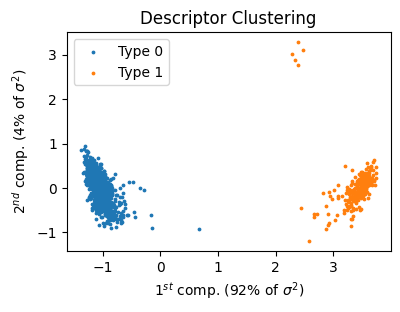

In [20]:
%matplotlib inline
fig = plt.figure(figsize=(4,3))
gs = GridSpec(1,1, hspace=0.45, right=0.99, left=0.18, top=0.9, bottom=0.17)
ax1 = fig.add_subplot(gs[0])
sta.plot_clustering(fig=fig, ax=ax1)

In [21]:

sta_st = msbd_res[:]
#sta_st = la_results[:]
sta_st.site_network = sta_res

In [22]:
sta_st.compute_site_occupancies()
print(sta_st.percent_unassigned)

0.046836496836496835


In [23]:
ja3 = sitator.dynamics.JumpAnalysis()
ja3.run(sta_st)

/mnt/d/Internship/Summer Internship 2025/CPDyAnafork-master/CPDyAnafork-master/sitator-master/sitator/dynamics/JumpAnalysis.py:220: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(lbls)
/mnt/d/Internship/Summer Internship 2025/CPDyAnafork-master/CPDyAnafork-master/sitator-master/sitator/dynamics/JumpAnalysis.py:221: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(lbls)


Text(0.5, 1.0, '')

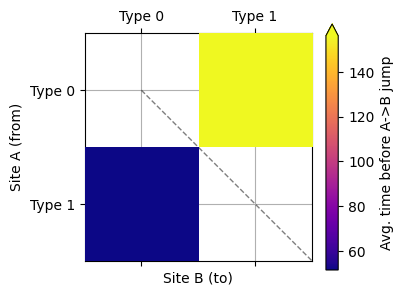

In [24]:
fig = plt.figure(figsize=(4,3))
gs = GridSpec(1,1, top=0.9, left=0.2, right=0.91, bottom=0.08)
ax = fig.add_subplot(gs[0])

ja3.plot_jump_lag(sta_st.site_network, mode='type',min_n_events=4, fig=fig, ax=ax)
ax.set_title("")
#plt.savefig("LASO-{}-jump-lag-by-type.pdf".format(T))

In [25]:
import sitator.network.DiffusionPathwayAnalysis

if sta_st.site_network.has_attribute('site_diffusion_pathway'):
    sta_st.site_network.remove_attribute('site_diffusion_pathway')
    sta_st.site_network.remove_attribute('edge_diffusion_pathway')

dpa = sitator.network.DiffusionPathwayAnalysis(connectivity_threshold=1, minimum_n_sites=0)
dpa.run(sta_st.site_network)

(<sitator.SiteNetwork.SiteNetwork at 0x7fdd3906e2c0>,)

[]

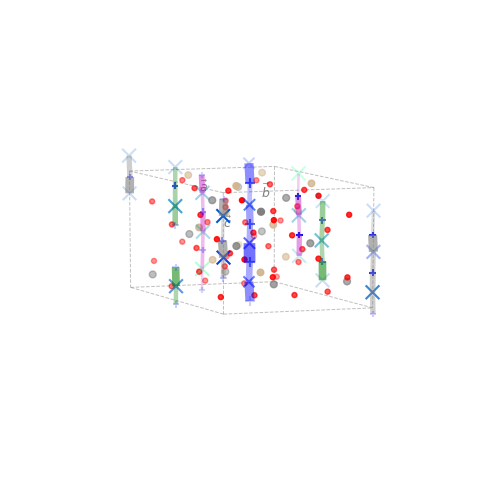

In [26]:
%matplotlib inline
import sitator.visualization

snp = sitator.visualization.SiteNetworkPlotter(site_mappings={
                'color' : 'residence_times', 
                            'size' : 'occupancies', 
                            'marker' : 'site_types'},
                         edge_mappings={
                             'intensity' : 'p_ij',
                             'width' : 'n_ij',
                             'group' : 'edge_diffusion_pathway'
                                       },
                         min_width_threshold = 0.00002,
                         min_color_threshold = 0.005)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(12, 20)
f = snp(sta_st.site_network, fig=fig, ax=ax)
ax.set_yticks([])
ax.set_xticks([])
ax.set_zticks([])
#plt.savefig('LASO-{}-final-analysis.png'.format(T), dpi=600)

# RDF by each site type:

In [27]:
%matplotlib inline
from ase import Atom

site_trajectory =  msbd_res.traj
static_m = np.where(msbd_res.site_network.static_mask)[0]
mobile_m = np.where(msbd_res.site_network.mobile_mask)[0]

len_static_m = len(static_m)
newatoms = msbd_res.site_network.static_structure.copy()

newatoms.append(Atom('Li', (0.,0.,0.)))

positions_type =  [[] for _ in range(len(np.unique(sta_res.site_types)))]

site_indices = range(site_trajectory.max()+1)

for i1, site_idx in enumerate(site_indices):
    timesteps, indices = np.where(site_trajectory == site_idx)
    traj_this_site = np.zeros((len(timesteps), len_static_m+1 ,3))
    for t_idx, (timestep, li_index) in enumerate(zip(timesteps, indices)):
        try:
            traj_this_site[t_idx, :len_static_m, :] =  msbd_res._real_traj[timestep, static_m, :]
            traj_this_site[t_idx, len_static_m, :] = msbd_res._real_traj[timestep, mobile_m[li_index], :]
        except IndexError:
            break
    positions_type[sta_res.site_types[site_idx]].append(traj_this_site)

In [28]:
rdf_results = []

for idx, positions_this_type in enumerate(positions_type):
    newt = Trajectory(atoms=newatoms)
    newt.set_positions(np.concatenate(positions_this_type, axis=0))
    rdf = RDF(trajectory=newt)
    rdf_results.append(rdf.run(radius=5.,
             species_pairs=(['Li', 'O'],['Li', 'Si'],['Li', 'Al'], ),
             stepsize=1, istop=None, nbins=80))

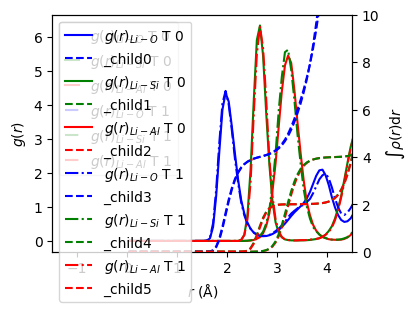

In [29]:
%matplotlib inline
fig = plt.figure(figsize=(4,3))
gs = GridSpec(1,1, left=0.11, right=0.86, top=0.97, bottom=0.18)
ax = fig.add_subplot(gs[0])
ax2 = ax.twinx()
colors = ['r', 'g', 'b', 'black']
# for i, rdf_res in enumerate(rdf_results[:2]):
handles = []
linestyles = ['-', '-.']
colordict = {'Li_Si':'g', 'Li_Al':'r', 'Li_O':'b'}
for i in range(len(rdf_results)):
    handles += plot_rdf(rdf_results[i], ax=ax, ax2=ax2, show=False, 
        plot_params=dict(colordict=colordict, linestyle=linestyles[i],  labelspec='T {}'.format(i)), 
        plot_params2=dict(label=None))

ax2.set_ylim(0,10)
ax.set_xlim(-1.5,4.5)
plt.legend(handles = handles, loc=2)